# Zero-shot Gender Classification with OpenAI's CLIP

State-of-the-art (SOTA) computer vision (CV) models are characterized by a restricted understanding of the visual world based on their training data.

developed mainly on [Interacting_with_CLIP](https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb)

In [2]:
!unzip /content/Adience_Test.zip -d /content/Adience_Test

Archive:  /content/Adience_Test.zip
replace /content/Adience_Test/0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Preparation for Colab

In [3]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qynbmbcb
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-qynbmbcb


In [4]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 1.12.1+cu113


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [5]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f91a1c8d4d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [9]:
# Setting up input images

original_images = []
images = []
labels = []
plt.figure(figsize=(16, 5))

filepath = '/content/Adience_Test'

i = 0
img_range = 4000

for filename in [filename for filename in os.listdir(filepath) if filename.endswith(".png") or filename.endswith(".jpg")]:

    image = Image.open(os.path.join(filepath, filename)).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))
    if '0_' in filename:
      labels.append('f')
    else:
      labels.append('m')
    i = i + 1
    if i == img_range:
      break
plt.tight_layout()

<Figure size 1152x360 with 0 Axes>

In [10]:
text_descriptions = ["This is a photo of a baby girl.", 
            "This is a photo of a baby boy.",
            "This is a photo of a young girl.", 
            "This is a photo of a young boy.",
            "This is a photo of a young woman.",
            "This is a photo of a young man.",
            "This is a photo of a old woman.",
            "This is a photo of a old man."]
text_tokens = clip.tokenize(text_descriptions).cuda()
image_input = torch.tensor(np.stack(images)).cuda()

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [11]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [29]:
predictions = top_labels[:,0]

num_correct = 0

text_to_gender = {
    0 : 'f',
    1 : 'm' ,
    2 : 'f',
    3 : 'm', 
    4 : 'f',
    5 : 'm', 
    6 : 'f',
    7 : 'm'  
}

text_to_gender

for i in range(len(labels)):
  gt = labels[i]
  pre = text_to_gender.get(predictions[i].item())
  if (gt == pre):
    num_correct = num_correct + 1
  
acc = (num_correct / len(labels)) * 100
acc

96.85000000000001

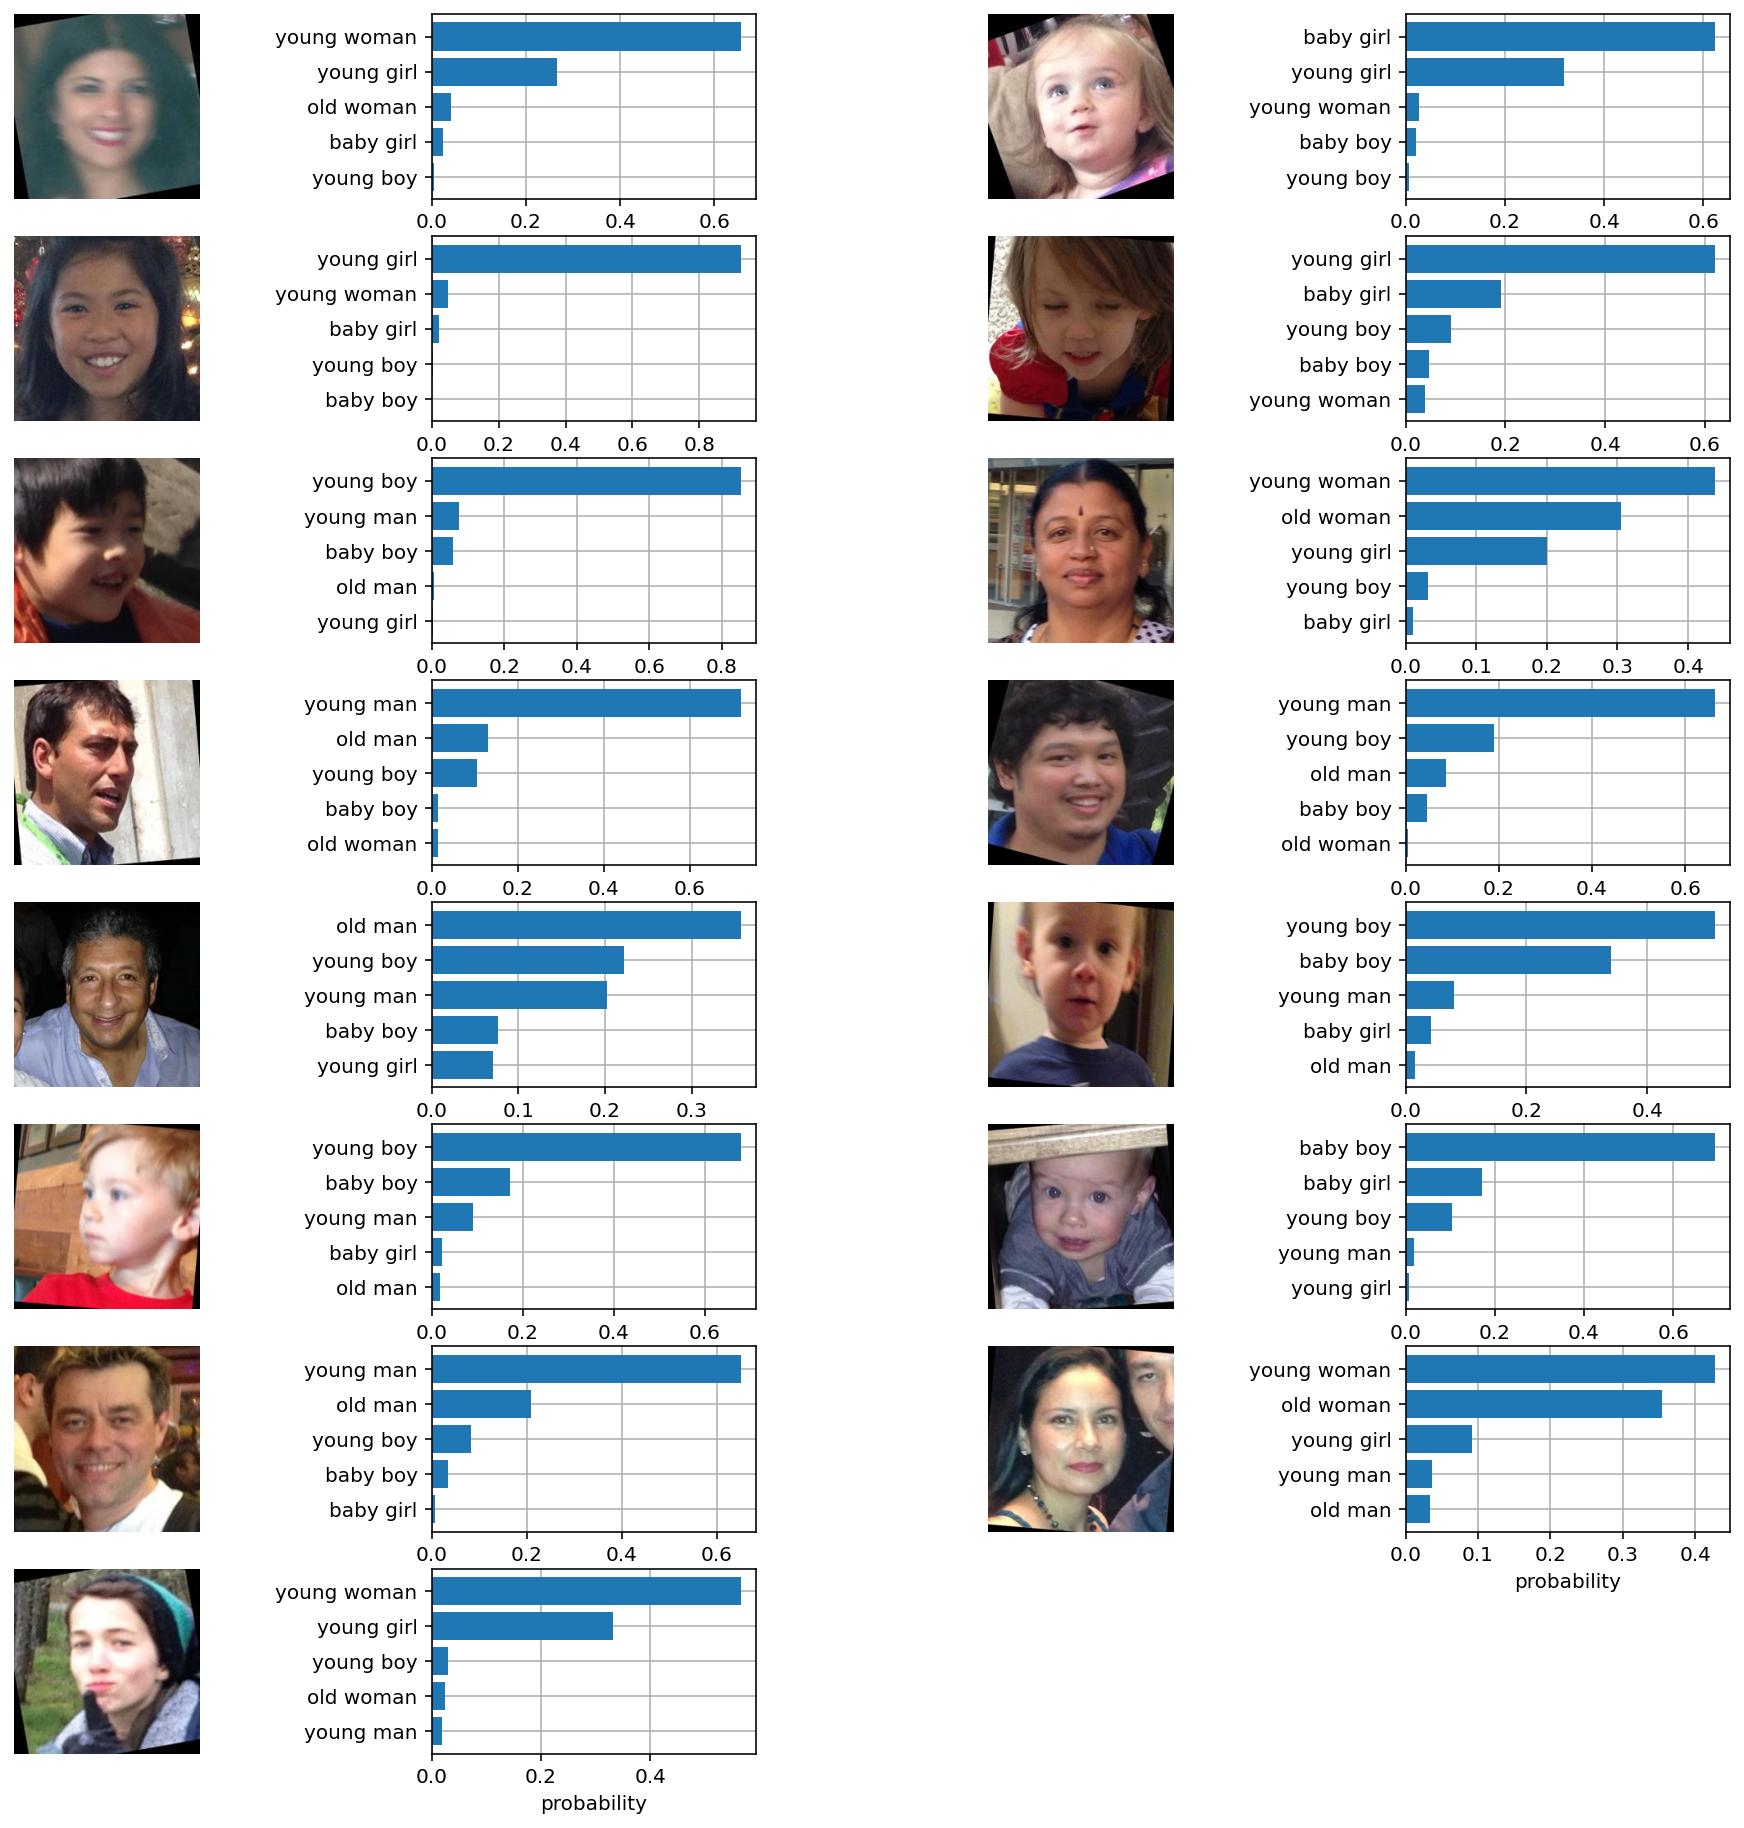

In [42]:
plt.figure(figsize=(16, 16))

classes = ["baby girl", "baby boy", "young girl", "young boy",
           "young woman", "young man", "old woman", "old man"]

for i, image in enumerate(original_images[:15]):
    plt.subplot(8, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(8, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()